In [1]:
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import dataloader as dl
import models as models
import train as train

import wandb as wandb

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: adrian-dendorfer (adrian_s_playground). Use `wandb login --relogin` to force relogin


In [19]:
h_params = {
    "num_epochs": 100, 
    "batch_size": 32, 
    "hidden_size1": 4096, # 512, 
    "hidden_size2": 256, #128, 
    "lr": 0.02,  

    "length_sample": 100, 
    "number_samples": 1,
}

In [20]:
# Get dataloaders
train_loader = dl.build_dataloader("train", h_params["length_sample"], h_params["batch_size"], h_params["number_samples"])
val_loader = dl.build_dataloader("val", h_params["length_sample"], h_params["batch_size"], h_params["number_samples"])
test_loader = dl.build_dataloader("test", h_params["length_sample"], h_params["batch_size"], h_params["number_samples"])

# Get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Get model
# model = models.SimpleClassifierNN(61*100, 256, 32)
model = models.ShallowConvNet(n_channels = 61, n_classes = 1, input_time_length = 100, n_filters=40, filter_time_length=25, pool_time_length=75, pool_time_stride=15) #, drop_prob=0.5)
model.to(device)

cuda:0


ShallowConvNet(
  (temporal_conv): Conv2d(61, 40, kernel_size=(1, 25), stride=(1, 1), padding=valid)
  (spatial_conv): Conv2d(40, 40, kernel_size=(61, 40), stride=(1, 1), padding=same)
  (pooling): AvgPool2d(kernel_size=(1, 75), stride=(15, 1), padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_classification): Linear(in_features=80, out_features=1, bias=True)
  (final_activation): Sigmoid()
)

In [24]:
# Grid Search

LR = [0.05] #, 0.1, 0.05, 0.02, 0.01]
EPOCHS = [10]

for epochs in EPOCHS: 
    for lr in LR: 
        
        h_params["lr"] = lr
        h_params["num_epochs"] = epochs
        train.train_model(model, train_loader, val_loader, h_params, device) #, overfitting=32)
        
# train.train_model(model, train_loader, val_loader, h_params, device)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train_accuracy,██▅▁▁▁▁▁▁▁
train_loss,▁▁▄███████
train_loss_accumulating,▁▁▄███████
val_accuracy,█▅▁▁▁▁▁▁▁▁
val_loss,▁▄████████
val_loss_accumulating,▁▄████████
train_accuracy,-74.0
train_loss,75.0
train_loss_accumulating,75.0
val_accuracy,-74.0
val_loss,75.0


cuda:0
Epoch [1/10], Validation Loss: 0.0186
Epoch [2/10], Validation Loss: 0.0002
Epoch [3/10], Validation Loss: 10.0342
Epoch [4/10], Validation Loss: 23.3697
Epoch [5/10], Validation Loss: 30.9915
Epoch [6/10], Validation Loss: 36.9544
Epoch [7/10], Validation Loss: 39.2504
Epoch [8/10], Validation Loss: 47.3455
Epoch [9/10], Validation Loss: 52.4763
Epoch [10/10], Validation Loss: 53.8282


In [ ]:
# correct = 0
# total = 0
# # since we're not training, we don't need to calculate the gradients for our outputs
# with torch.no_grad():
#     for data in test_loader:
#         X, y = data
#         X,y = X.to(device), y.to(device)
#         # calculate outputs by running images through the network
#         outputs = model(X)
#         # the class with the highest energy is what we choose as prediction
#         # _, predicted = torch.max(outputs.data, 1)
#         total += y.size(0)
#         correct += (outputs == y).sum().item()

# print(f'Accuracy of the network on the test set: {100 * correct // total} %')

Accuracy of the network on the test set: 0 %


## Sweep with WandB


In [ ]:
def build_network(hidden_size_1, hidden_size_2, device):  # dropout):
    model = model.SimpleClassifierNN(hidden_size1=hidden_size_1, hidden_size2=hidden_size_2)
    return model.to(device)

In [ ]:
val_loader = train_loader

In [ ]:
# sweep_config = {
#     "method": "random",
#     "early_terminate": "hyperband",
#     "metric": { "name": "loss", "goal": "minimize"},
#     "parameters": {
#         "batch_size": {
#             "distribution": "q_log_uniform_values",
#             "max": 256,
#             "min": 2,
#             "q": 8,
#         },
#         # "dropout": {"values": [0.3, 0.4, 0.5]},
#         # "epochs": {"value": 1},
#         "fc_layer_size": {"values": [4096, 2048, 1024, 512]},
#         "learning_rate": {"distribution": "uniform", "max": 0.1, "min": 0},
#         "optimizer": {"values": ["adamw", "adam", "sgd"]},
#     },
# }

# # import pprint #pretty print
# # pprint.pprint(sweep_config)


In [ ]:
# def train_wandb_main(config=None):
#     # Initialize a new wandb run
#     with wandb.init(config=config):
#         # If called by wandb.agent, as below,
#         # this config will be set by Sweep Controller
#         config = wandb.config

#         loader = dl.build_train_dataloader(config.batch_size)
#         model = models.build_network(config.fc_layer_size, device) # config.dropout)
#         optimizer = train.build_optimizer(model, config.optimizer, config.learning_rate)

#         for epoch in range(config.epochs):
#             avg_loss = train.train_epoch(model, loader, optimizer)
#             wandb.log({"loss": avg_loss, "epoch": epoch})           

In [ ]:
# sweep_id = wandb.sweep(sweep_config, project="classifing-eeg")
# wandb.agent(sweep_id, train_wandb_main, count=5)

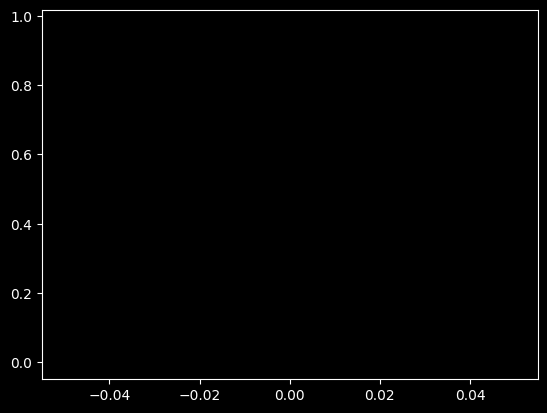

In [ ]:
# dataiter = iter(test_loader)
# data_test = next(dataiter)
# # data_test
# test_X = data_test[0].to(device)
# output = model(test_X)

# plt.plot(output.to("cpu").detach().numpy())
# plt.plot(data_test[1].to("cpu").detach().numpy())

In [ ]:
# for i in enumerate(val_loader): 
#     # print(i[0]) 
#     print(i[1][0].shape)

# for i in enumerate(train_loader): 
#     # print(i[0]) 
#     print(i[1][0].shape)